# Posterior Collapse Experiments

Posterior collapse is phenomenon that occurs when the approximate posterior distribution, in our case $q(a|x)$, collapses towards the prior distribution $p(a)$. In this scenario, the model minimizes the regularization term (KL divergence) at the expense of ignoring the conditioning data (input frames). In this notebook we visualize some experiments refered to Posterior Collapse. Given a known collapsed seed `(seed = 55)`, we perform an experiment with and without $\beta$-annealing and observe the differences in the latent space.



## Load the Checkpoints and the Evaluation Data

In [6]:
import torch
from pathlib import Path
import yaml

from kvae.model.model import KVAE
from kvae.vae.config import KVAEConfig
from kvae.train.utils import parse_device, build_dataloaders
from kvae.train.train import evaluate
from kvae.train.imputation import impute_epoch, impute_batch

import seaborn as sns
import matplotlib.pyplot as plt


def load_checkpoint(checkpoint_path, device='auto'):
    """
    Load a trained KVAE model from checkpoint.
    
    Args:
        checkpoint_path: Path to checkpoint file (.pt)
        device: Device to load model on ('auto', 'cuda', 'cpu', 'mps')
    
    Returns:
        model: Loaded KVAE model
        checkpoint: Full checkpoint dictionary with training info
        device: The actual device being used
    """
    checkpoint_path = Path(checkpoint_path)
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    
    device = parse_device(device)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Initialize model with config
    cfg = KVAEConfig()
    model = KVAE(cfg).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state'])
    model.eval()
    
    print(f"✓ Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"  Train loss: {checkpoint['train_loss']:.6f}")
    print(f"  Val loss: {checkpoint['val_loss']:.6f}")
    
    return model, checkpoint, device


# Example usage:
# runs/20251213-205257 -> Training with beta schedule
# runs/20251213-233648 -> Training collapsed

runs_path = Path("../runs/20251216-174816")
checkpoint_path = runs_path / "checkpoints/kvae-ckpt-epoch=030.pt"

model, ckpt, device = load_checkpoint(checkpoint_path, device='cpu')
print(f"\nModel loaded on: {device}")


✓ Loaded checkpoint from epoch 30
  Train loss: 9.360204
  Val loss: 9.298553

Model loaded on: cpu


In [7]:
# Load config from the run directory
config_path = runs_path / "config.yaml"

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Configuration:
  dataset: {'kwargs': {'load_in_memory': True, 'normalize': False, 'seq_len': 20}, 'num_workers': 1, 'path': 'C:\\Users\\adiaz\\OneDrive\\Pictures\\Documents\\MVA\\First_Semester\\Proba_Graph_Models\\data\\box.npz', 'type': 'pymunk', 'val_split': 0.2}
  training: {'add_imputation_plots': True, 'batch_size': 32, 'ckpt_every': 5, 'device': 'cpu', 'gpus': 1, 'logdir': 'runs', 'lr': 0.007, 'max_epochs': 30, 'pretrain_vae_epochs': 0, 'seed': 55, 'warmup_epochs': 10}
  transforms: {'add_noise_std': 0.0}


In [8]:
# Load data
train_loader, val_loader = build_dataloaders(
    config['dataset'], 
    batch_size=config['training']['batch_size']
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Using device: {device}")

Train batches: 125
Val batches: 32
Using device: cpu


## Evaluate model on validation set

In [9]:
# Manual evaluation loop - collect detailed outputs for visualization
model.eval()

# Get one batch for detailed analysis
sample_batch = next(iter(val_loader))
x = sample_batch["images"].float().to(device)
B, T = x.shape[:2]

# 1. Full reconstruction (no masking)
with torch.no_grad():
    model.kalman_filter.dyn_params.reset_state()
    mask = torch.ones(B, T, device=device, dtype=x.dtype)
    
    outputs = model(x, mask=mask)
    losses = model.compute_loss(x, outputs, kf_weight=1.0, mask=mask)
    
print("Full Reconstruction Outputs:")
print(f"  Loss: {losses['loss']:.6f}")
print(f"  ELBO VAE: {losses['elbo_vae_total']:.6f}")
print(f"  ELBO KF: {losses['elbo_kf']:.6f}")
print(f"\nAvailable outputs: {list(outputs.keys())}")
print(f"  x_recon shape: {outputs['x_recon'].shape}")
print(f"  a_samples shape: {outputs['a_samples'].shape}")
print(f"  mus_smooth shape: {outputs['mus_smooth'].shape}")
print(f"  mus_filt shape: {outputs['mus_filt'].shape}")



c:\Users\adiaz\OneDrive\Pictures\Documents\MVA\First_Semester\Proba_Graph_Models\kalman-vae\.venv\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Full Reconstruction Outputs:
  Loss: 1.876327
  ELBO VAE: -1.381202
  ELBO KF: -0.495125

Available outputs: ['x_recon', 'x_logits', 'a_samples', 'a_mu', 'a_var', 'mus_smooth', 'Sigmas_smooth', 'mus_filt', 'Sigmas_filt', 'mus_pred', 'Sigmas_pred', 'ABC', 'u']
  x_recon shape: torch.Size([32, 20, 1, 32, 32])
  a_samples shape: torch.Size([32, 20, 2])
  mus_smooth shape: torch.Size([32, 20, 4, 1])
  mus_filt shape: torch.Size([32, 20, 4, 1])


## Collapsed Seed

In [15]:
# runs/20251213-233648 -> Training collapsed
runs_path_collapsed = Path("../runs/20251216-164151")
checkpoint_path = runs_path_collapsed / "checkpoints/kvae-best.pt"

collapsed_model, ckpt, device = load_checkpoint(checkpoint_path, device='cpu')
print(f"\nModel loaded on: {device}")

# Manual evaluation loop - collect detailed outputs for visualization
collapsed_model.eval()
# Get one batch for detailed analysis
sample_batch = next(iter(val_loader))
x = sample_batch["images"].float().to(device)
B, T = x.shape[:2]

# 1. Full reconstruction (no masking)
with torch.no_grad():
    collapsed_model.kalman_filter.dyn_params.reset_state()
    mask = torch.ones(B, T, device=device, dtype=x.dtype)
    
    collapsed_outputs = collapsed_model(x, mask=mask)
    collapsed_losses = collapsed_model.compute_loss(x, collapsed_outputs, kf_weight=1.0, mask=mask)



✓ Loaded checkpoint from epoch 26
  Train loss: 30.288516
  Val loss: 30.279367

Model loaded on: cpu


c:\Users\adiaz\OneDrive\Pictures\Documents\MVA\First_Semester\Proba_Graph_Models\kalman-vae\.venv\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [16]:
idx = 14
import numpy as np
var_tag = 'a_var'
mu_tag = 'a_mu'
a_vae_var = np.log(outputs[var_tag].cpu().numpy()[idx,:,:]) # [T, a_dim]
a_vae_var_collapsed = np.log(collapsed_outputs[var_tag].cpu().numpy()[idx,:,:])  # [T, a_dim]

a_vae_mu = outputs[mu_tag].cpu().numpy()[idx,:,:]  # [T, a_dim]
a_vae_mu_collapsed = collapsed_outputs[mu_tag].cpu().numpy()[idx,:,:]  # [T, a_dim]

a_dim = a_vae_var.shape[1]
print(a_vae_var.shape)

(20, 2)


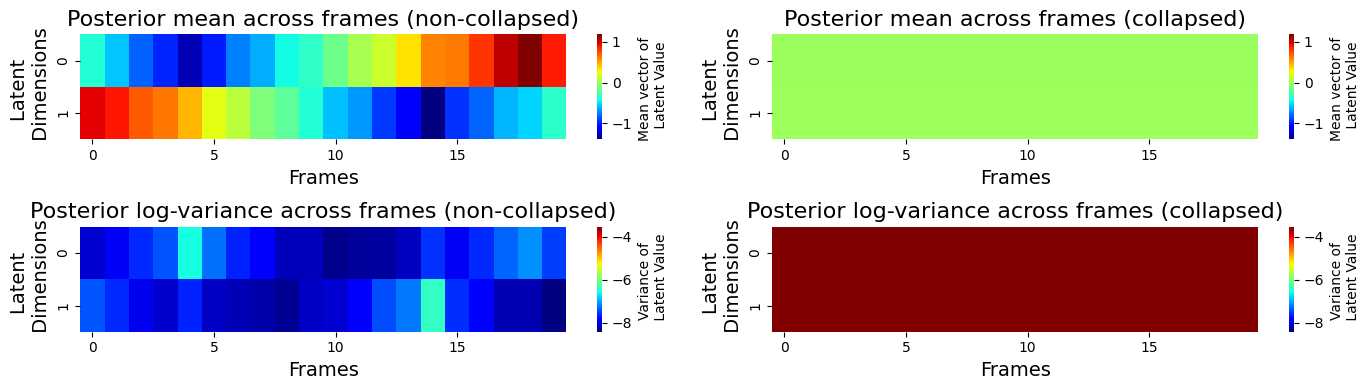

In [17]:
def plot_posterior_heatmaps(
    a_mu: np.ndarray,
    a_mu_collapsed: np.ndarray,
    a_var: np.ndarray,
    a_var_collapsed: np.ndarray,
    fs_title: int = 16,
    fs_labels: int = 14,
    cmap: str = 'jet',
    tick_freq: int = 5,
):
    """
    Plot posterior mean and log-variance heatmaps for non-collapsed and
    collapsed models in a single 2x2 figure.

    Subplots (top-left to bottom-right):
      1) Posterior mean (non-collapsed)
      2) Posterior mean (collapsed)
      3) Posterior log-variance (non-collapsed)
      4) Posterior log-variance (collapsed)

    Args:
        a_mu: [T, a_dim] posterior mean from the non-collapsed model.
        a_mu_collapsed: [T, a_dim] posterior mean from the collapsed model.
        a_var: [T, a_dim] posterior log-variance from the non-collapsed model.
        a_var_collapsed: [T, a_dim] posterior log-variance from the collapsed model.
        fs_title: Font size for subplot titles.
        fs_labels: Font size for axis labels.
        cmap: Colormap for heatmaps.
        tick_freq: Show every Nth x-tick label.
    """
    # Color scales: keep consistent within means and within variances
    mu_vmin = np.nanmin([np.nanmin(a_mu), np.nanmin(a_mu_collapsed)])
    mu_vmax = np.nanmax([np.nanmax(a_mu), np.nanmax(a_mu_collapsed)])
    var_vmin = np.nanmin([np.nanmin(a_var), np.nanmin(a_var_collapsed)])
    var_vmax = np.nanmax([np.nanmax(a_var), np.nanmax(a_var_collapsed)])

    fig, axes = plt.subplots(2, 2, figsize=(14, 4))

    # Mean (non-collapsed)
    ax = axes[0, 0]
    sns.heatmap(
        a_mu.T,
        cmap=cmap,
        vmin=mu_vmin,
        vmax=mu_vmax,
        cbar_kws={'label': 'Mean vector of \n Latent Value'},
        ax=ax,
        xticklabels=tick_freq,
    )
    ax.set_xlabel('Frames', fontsize=fs_labels)
    ax.set_ylabel('Latent \n Dimensions', fontsize=fs_labels)
    ax.set_title('Posterior mean across frames (non-collapsed)', fontsize=fs_title)

    # Mean (collapsed)
    ax = axes[0, 1]
    sns.heatmap(
        a_mu_collapsed.T,
        cmap=cmap,
        vmin=mu_vmin,
        vmax=mu_vmax,
        cbar_kws={'label': 'Mean vector of \n Latent Value'},
        ax=ax,
        xticklabels=tick_freq,
    )
    ax.set_xlabel('Frames', fontsize=fs_labels)
    ax.set_ylabel('Latent \n Dimensions', fontsize=fs_labels)
    ax.set_title('Posterior mean across frames (collapsed)', fontsize=fs_title)

    # Log-variance (non-collapsed)
    ax = axes[1, 0]
    sns.heatmap(
        a_var.T,
        cmap=cmap,
        vmin=var_vmin,
        vmax=var_vmax,
        cbar_kws={'label': 'Variance of \n Latent Value'},
        ax=ax,
        xticklabels=tick_freq,
    )
    ax.set_xlabel('Frames', fontsize=fs_labels)
    ax.set_ylabel('Latent \n Dimensions', fontsize=fs_labels)
    ax.set_title('Posterior log-variance across frames (non-collapsed)', fontsize=fs_title)

    # Log-variance (collapsed)
    ax = axes[1, 1]
    sns.heatmap(
        a_var_collapsed.T,
        cmap=cmap,
        vmin=var_vmin,
        vmax=var_vmax,
        cbar_kws={'label': 'Variance of \n Latent Value'},
        ax=ax,
        xticklabels=tick_freq,
    )
    ax.set_xlabel('Frames', fontsize=fs_labels)
    ax.set_ylabel('Latent \n Dimensions', fontsize=fs_labels)
    ax.set_title('Posterior log-variance across frames (collapsed)', fontsize=fs_title)

    plt.tight_layout()
    plt.savefig("posterior_collapse_heatmaps.png", dpi=300)
    plt.show()
    


# Call the function using arrays prepared above
plot_posterior_heatmaps(
    a_vae_mu,
    a_vae_mu_collapsed,
    a_vae_var,
    a_vae_var_collapsed,
)


In [18]:
from pathlib import Path
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt


def get_event_accumulator(root: Path) -> event_accumulator.EventAccumulator:
    """Return an EventAccumulator for the latest TensorBoard event file under root.

    Args:
        root: Path to a run directory that contains 'events.out.tfevents.*' files.

    Raises:
        FileNotFoundError: If no event files are found.

    Returns:
        Configured and reloaded EventAccumulator.
    """
    event_files = sorted(Path(root).rglob("events.out.tfevents.*"))
    if not event_files:
        raise FileNotFoundError(f"No TensorBoard event files found under '{root}'")
    event_file = event_files[-1]
    print(f"Using event file: {event_file}")
    acc = event_accumulator.EventAccumulator(str(event_file), size_guidance={"scalars": 0})
    acc.Reload()
    return acc


def list_scalar_tags(acc: event_accumulator.EventAccumulator) -> list[str]:
    """Return all scalar tags available in the accumulator and print them."""
    scalar_tags = acc.Tags().get("scalars", [])
    print("Available scalar tags:")
    for tag in scalar_tags:
        print(" -", tag)
    return scalar_tags


In [44]:
from kvae.vae.losses import LinearScheduler

# Initialize LinearScheduler with the specified parameters
scheduler = LinearScheduler(
    type('Config', (), {
        'scheduled_beta': True,
        'start_epoch': 0,
        'end_epoch': 5,
        'start_val': 0.0,
        'end_val': 1.0
    })()
)

We define the scheduler just for plotting.

Using event file: ..\runs\20251216-164151\events.out.tfevents.1765899787.Days-machine.3292.0
Available scalar tags:
 - train/loss
 - train/elbo_kf
 - train/elbo_vae_total
 - train/kl_vae
 - train/active_units
 - val/loss
 - val/elbo_kf
 - val/elbo_vae_total
 - val/kl_vae
 - val/active_units
 - train/learning_rate
Using event file: ..\runs\20251216-174816\events.out.tfevents.1765903793.Days-machine.23640.0
Available scalar tags:
 - train/loss
 - train/elbo_kf
 - train/elbo_vae_total
 - train/kl_vae
 - train/active_units
 - val/loss
 - val/elbo_kf
 - val/elbo_vae_total
 - val/kl_vae
 - val/active_units
 - train/learning_rate


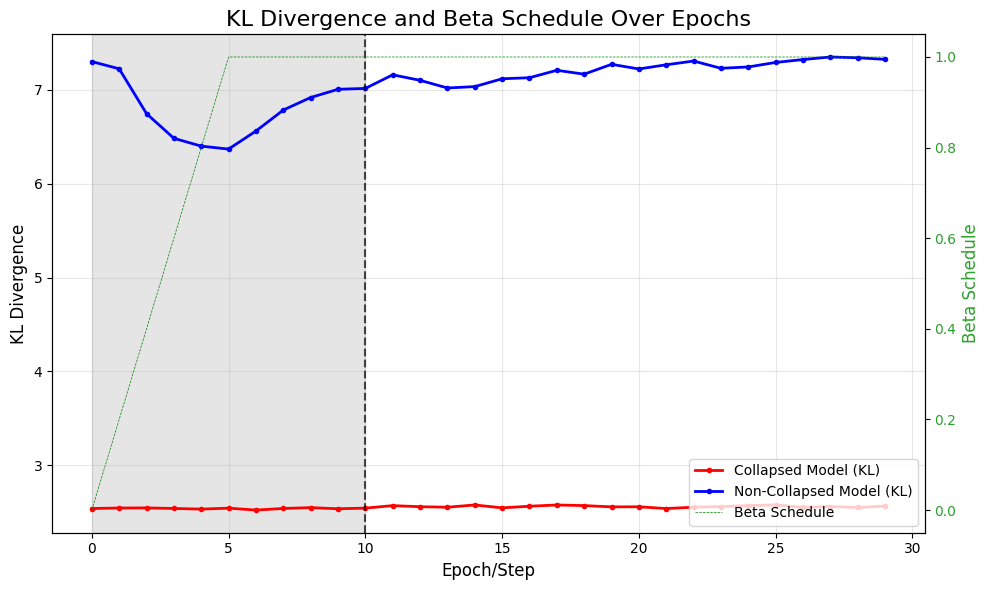

In [ ]:


acc = get_event_accumulator(runs_path_collapsed)
tags = list_scalar_tags(acc)
fs_title = 16
tag = "val/kl_vae"
scalars = acc.Scalars(tag)
steps = [s.step for s in scalars]
values_collapsed = [-s.value for s in scalars]

acc = get_event_accumulator(runs_path)
tags = list_scalar_tags(acc)

scalars = acc.Scalars(tag)
steps = [s.step for s in scalars]
values = [-s.value for s in scalars]

# Get warmup value from config (default to 10 if not found)
warmup_steps = config.get('training', {}).get('beta_warmup_steps', 10)

# Calculate beta values for each epoch
beta_values = [scheduler.get_beta(epoch) for epoch in range(int(max(steps)) + 1)]
epochs = list(range(len(beta_values)))

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left y-axis: KL Divergence
ax1.set_xlabel("Epoch/Step", fontsize=12)
ax1.set_ylabel("KL Divergence", fontsize=12)
ax1.tick_params(axis='y')

# Add gray background for warmup period
ax1.axvspan(0, warmup_steps, alpha=0.2, color='gray', label='Warmup')

# Plot KL divergence
line1 = ax1.plot(steps, values_collapsed, '-r.', label='Collapsed Model (KL)', linewidth=2)
line2 = ax1.plot(steps, values, '-b.', label='Non-Collapsed Model (KL)', linewidth=2)

# Add vertical line at warmup end
ax1.axvline(x=warmup_steps, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

ax1.grid(True, alpha=0.3)

# Right y-axis: Beta values
ax2 = ax1.twinx()
ax2.set_ylabel("Beta Schedule", fontsize=12, color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Plot beta schedule
line3 = ax2.plot(epochs, beta_values, 'g--', label='Beta Schedule', linewidth=0.5)

# Combine legends from both axes
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower right', fontsize=10)

plt.title('KL Divergence and Beta Schedule Over Epochs', fontsize=fs_title)
fig.tight_layout()
plt.show()

This figure demonstrates that the divergence of the collapsed model remains constant across all epochs. Conversely, in the $\beta$-annealing training, the divergence is weighted by a $\beta$-scheduler. The plot indicates that while the divergence is minimized during the first 5 epochs, the VAE still learns to reconstruct the image during this initial phase. Once the VAE is able to reconstruct the image, the loss function allows the divergence to increase in order to minimize the total loss of the whole system.